In [8]:
!pip install -q datasets


#1 Descomprimir el Dataset

In [ ]:
import zipfile
import os

zip_file_path = "/content/drive/MyDrive/Facultad/UADE/PFI/PFI 2025/dataset/dataset-soroban.zip"
destination_dir = "/content/dataset-soroban"

# Crea el directorio destino si no existe
os.makedirs(destination_dir, exist_ok=True)

# Extrae todo el contenido del ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print(f"Dataset descomprimido en: {destination_dir}")

Verificar el contenido

In [ ]:
base_dir = "/content/dataset-soroban/dataset-soroban" # Updated path

# Mostrar carpetas dentro del dataset
print("📁 Carpetas encontradas:")
for nombre in sorted(os.listdir(base_dir)):
    ruta = os.path.join(base_dir, nombre)
    # if os.path.isdir(ruta): # commented out to show all items
    print(" -", nombre)

# 2 Procesar todo el dataset y exportar a CSV

Toma Alrededor de 10 min

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import glob
import os
import re

def procesar_html_soroban(path_html, kyu):
    with open(path_html, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "html.parser")

    table = soup.find("table")
    if not table:
        return []

    rows = table.find_all("tr")
    header_cells = rows[0].find_all(["td", "th"])
    difficulties = [cell.get_text().count("★") for cell in header_cells]
    num_ejercicios = len(difficulties)
    ejercicios = []

    for col_idx in range(num_ejercicios):
        expression = []
        negative_present = False
        length = 0

        for row in rows[1:-2]:
            cells = row.find_all(["td", "th"])
            if col_idx < len(cells):
                raw = cells[col_idx].get_text(strip=True)
                if raw:
                    if raw.startswith("-"):
                        negative_present = True
                    expression.append(raw)
                    length += 1

        if length == 0:
            continue

        # Tokens con metadatos
        op_token = "<add_sub>"
        kyu_token = f"<kyu:{kyu}>"
        diff = difficulties[col_idx]
        diff_token = f"<diff:{diff}>"
        type_token = "<add_and_sub>" if negative_present else "<only_add>"
        length_token = f"<len:{length}>"

        # Cuenta formateada como texto: "5 + 9 + 4"
        formatted_expr = " + ".join(expression)

        # Secuencia completa (como antes)
        full_sequence = f"{op_token} {kyu_token} {diff_token} {type_token} {length_token} {formatted_expr}"

        # Agregamos como diccionario para armar columnas fácilmente
        ejercicios.append({
            "seq": full_sequence,
            "exp": formatted_expr,
            "len": length,
            "kyu": kyu,
            "diff": diff,
            "type": "add_and_sub" if negative_present else "only_add"
        })

    return ejercicios

# 🔁 Procesar todos los archivos desde una sola carpeta
base_dir = "/content/dataset-soroban/dataset-soroban"
html_files = glob.glob(f"{base_dir}/*.html")
todos_ejercicios = []

print(f"🔎 Archivos HTML encontrados: {len(html_files)}")

for path_html in html_files:
    filename = os.path.basename(path_html)
    match = re.match(r"(\d+)-kyu", filename)
    if not match:
        print(f"⚠️ Archivo con nombre inesperado: {filename}")
        continue

    kyu = int(match.group(1))
    ejercicios = procesar_html_soroban(path_html, kyu)
    todos_ejercicios.extend(ejercicios)

print(f"\n✅ Total de secuencias generadas: {len(todos_ejercicios)}")

# 💾 Guardar a CSV
df = pd.DataFrame(todos_ejercicios)
df.to_csv("entrenamiento_soroban.csv", index=False)
print("✅ CSV guardado como entrenamiento_soroban.csv")


🔎 Archivos HTML encontrados: 35400

✅ Total de secuencias generadas: 354000
✅ CSV guardado como entrenamiento_soroban.csv


Verifico el resultado

In [2]:
import pandas as pd

df = pd.read_csv("entrenamiento_soroban.csv")
print("✅ Total de secuencias en el CSV:", len(df))
df.sample(5, random_state=42)  # Mostrar 5 ejemplos aleatorios


✅ Total de secuencias en el CSV: 354000


,seq,exp,len,kyu,diff,type
81484,<add_sub> <kyu:6> <diff:2> <add_and_sub> <len:...,56 + 959 + 81 + 76 + 44 + -207 + 975 + 61 + 28...,15,6,2,add_and_sub
124528,<add_sub> <kyu:12> <diff:1> <only_add> <len:5>...,4 + 1 + 4 + 7 + 2,5,12,1,only_add
212993,<add_sub> <kyu:6> <diff:2> <only_add> <len:10>...,611 + 485 + 483 + 181 + 774 + 328 + 685 + 732 ...,10,6,2,only_add
62314,<add_sub> <kyu:12> <diff:3> <only_add> <len:5>...,2 + 3 + 6 + 8 + 3,5,12,3,only_add
128044,<add_sub> <kyu:5> <diff:2> <add_and_sub> <len:...,6214 + -2738 + 6039 + -2297 + 5456 + -1268 + 1...,10,5,2,add_and_sub


# 3. Análisis Exploratorio

## Gáficos

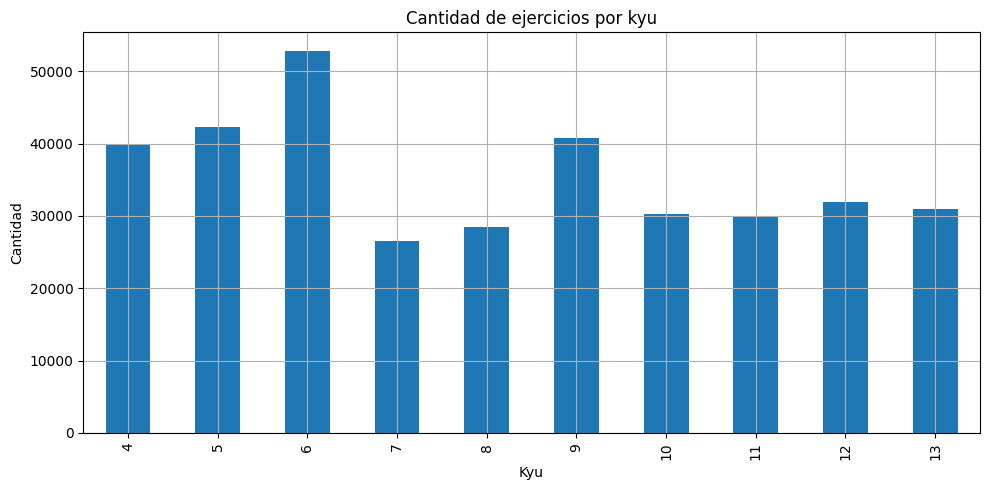

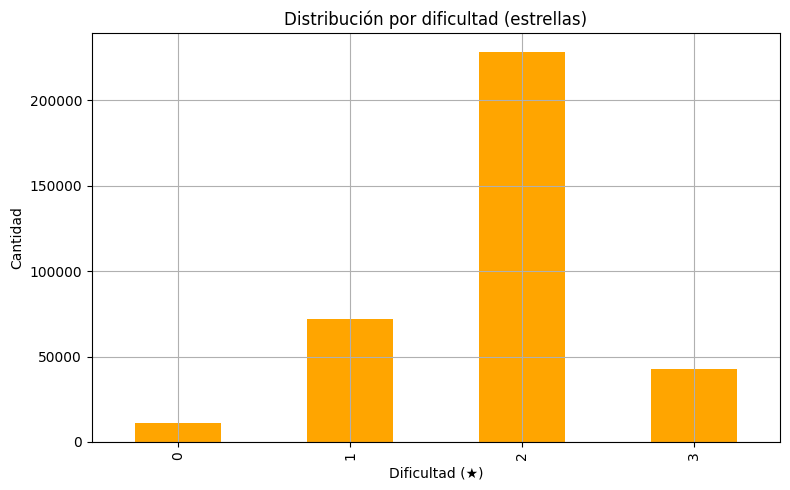

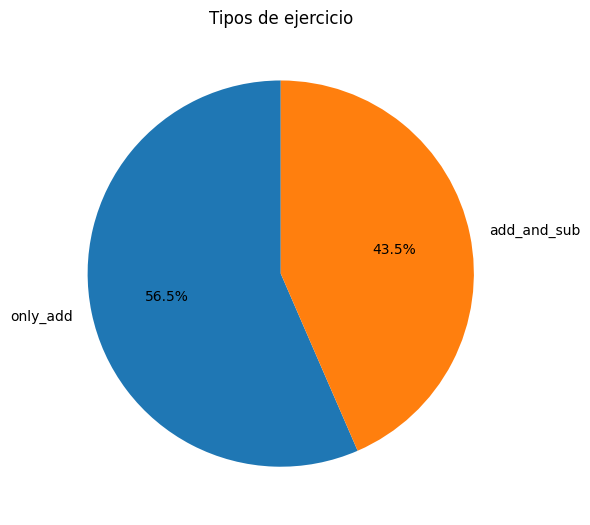

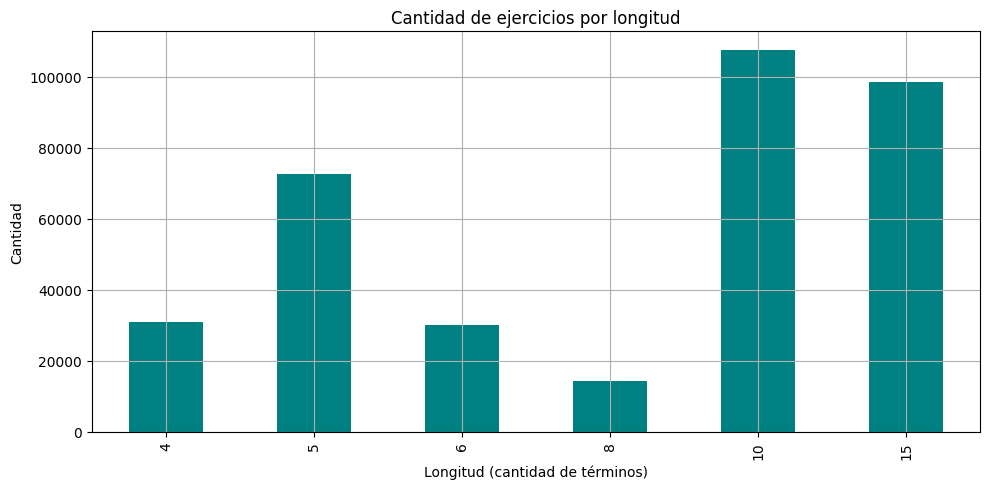

📈 Estadísticas de longitud:
- Mínima:  4
- Máxima:  15
- Promedio: 9.42


In [3]:
import matplotlib.pyplot as plt

# 📊 1. Distribución de ejercicios por Kyu
plt.figure(figsize=(10, 5))
df["kyu"].value_counts().sort_index().plot(kind="bar")
plt.title("Cantidad de ejercicios por kyu")
plt.xlabel("Kyu")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 2. Distribución por dificultad
plt.figure(figsize=(8, 5))
df["diff"].value_counts().sort_index().plot(kind="bar", color="orange")
plt.title("Distribución por dificultad (estrellas)")
plt.xlabel("Dificultad (★)")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 3. Distribución por tipo de ejercicio
plt.figure(figsize=(6, 6))
df["type"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90)
plt.title("Tipos de ejercicio")
plt.ylabel("")  # Saca la etiqueta del eje Y
plt.tight_layout()
plt.show()


# 📊 4. Conteo exacto por longitud
plt.figure(figsize=(10, 5))
df["len"].value_counts().sort_index().plot(kind="bar", color="teal")
plt.title("Cantidad de ejercicios por longitud")
plt.xlabel("Longitud (cantidad de términos)")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 5. Estadísticas básicas de longitud
print("📈 Estadísticas de longitud:")
print(f"- Mínima:  {df['len'].min()}")
print(f"- Máxima:  {df['len'].max()}")
print(f"- Promedio: {df['len'].mean():.2f}")

## Ejercicios sin dificultad

###Existen casos donde los ejercicios no poseen una dificultad asociada (diff). Por lo que hay que analizar cuántos son exactamente en comparación con el total

In [4]:
# Filtrar casos sin dificultad detectada correctamente
problemas = df[df["diff"].isna() | (df["diff"] == 0)]
print("⚠️ Ejercicios sin dificultad válida:", len(problemas))

# Mostrar algunos ejemplos
problemas["seq"].sample(5, random_state=42)
print(problemas["seq"].sample(5, random_state=42))


# Total de secuencias en el dataset
total = len(df)

# Total de secuencias con dificultad inválida
invalidas = len(df[df["diff"].isna() | (df["diff"] == 0)])

# Calcular porcentaje
porcentaje = (invalidas / total) * 100


print(f"🔢 Total de secuencias: {total}")
print(f"📊 Porcentaje afectado: {porcentaje:.2f}%")




⚠️ Ejercicios sin dificultad válida: 11248
181378    <add_sub> <kyu:6> <diff:0> <add_and_sub> <len:...
229795    <add_sub> <kyu:10> <diff:0> <add_and_sub> <len...
187781    <add_sub> <kyu:6> <diff:0> <only_add> <len:15>...
120782    <add_sub> <kyu:9> <diff:0> <add_and_sub> <len:...
201369    <add_sub> <kyu:10> <diff:0> <add_and_sub> <len...
Name: seq, dtype: object
🔢 Total de secuencias: 354000
📊 Porcentaje afectado: 3.18%


## Eliminación de Ejercicios Sin Dificultad
Al tratarse de un bajo porcentaje, se omitirán las secuencias con dificultad inválida.

In [5]:
import pandas as pd

# 📥 Leer el CSV original
df = pd.read_csv("entrenamiento_soroban.csv")

# 🧹 Filtrar ejercicios con dificultad válida (diff distinto de 0 y no nulo)
df_filtrado = df[df["diff"].notna() & (df["diff"] != 0)]

# 💾 Guardar el nuevo CSV filtrado
df_filtrado.to_csv("entrenamiento_soroban_filtrado.csv", index=False)

# ✅ Confirmación
print("✅ Dataset limpio guardado como 'entrenamiento_soroban_filtrado.csv'")
print(f"🔢 Total de filas originales: {len(df)}")
print(f"🔻 Total de filas después del filtrado: {len(df_filtrado)}")
print(f"❌ Filas eliminadas: {len(df) - len(df_filtrado)}")


✅ Dataset limpio guardado como 'entrenamiento_soroban_filtrado.csv'
🔢 Total de filas originales: 354000
🔻 Total de filas después del filtrado: 342752
❌ Filas eliminadas: 11248


## Gráfico con Datos Filtrados

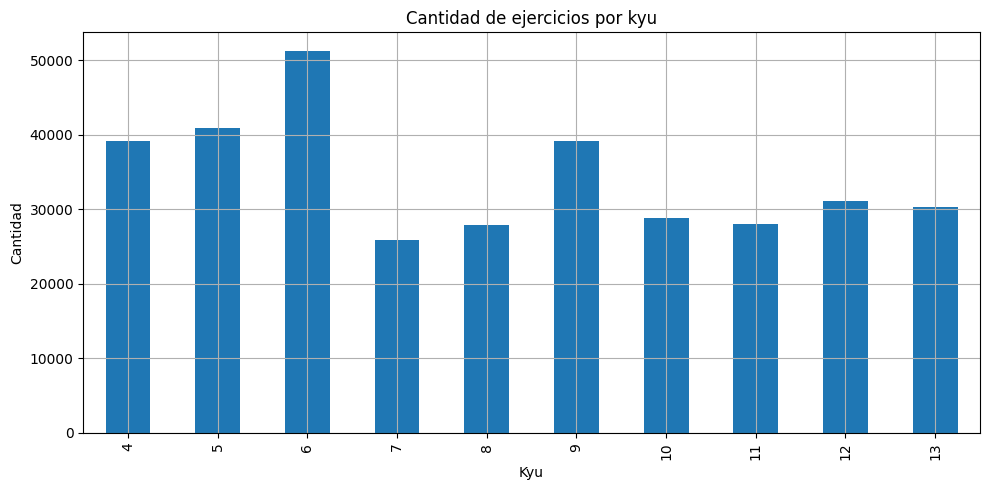

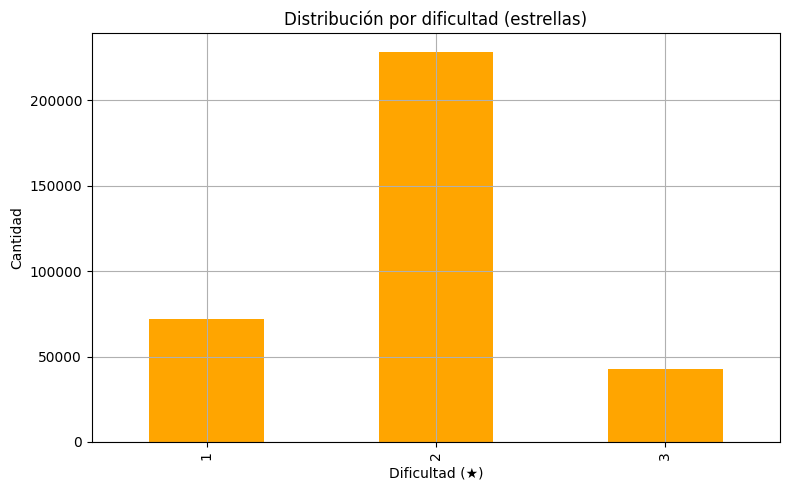

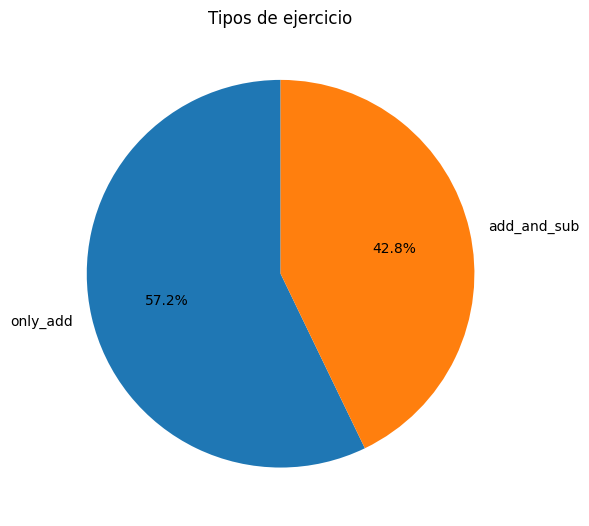

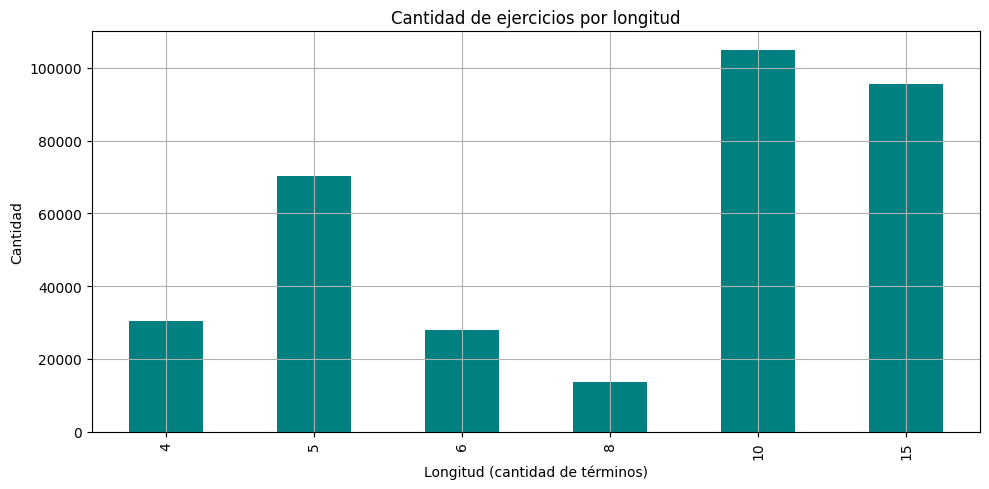

📈 Estadísticas de longitud:
- Mínima:  4
- Máxima:  15
- Promedio: 9.43


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 📥 Leer el dataset filtrado
df_filtrado = pd.read_csv("entrenamiento_soroban_filtrado.csv")

# 📊 1. Distribución de ejercicios por Kyu
plt.figure(figsize=(10, 5))
df_filtrado["kyu"].value_counts().sort_index().plot(kind="bar")
plt.title("Cantidad de ejercicios por kyu")
plt.xlabel("Kyu")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 2. Distribución por dificultad
plt.figure(figsize=(8, 5))
df_filtrado["diff"].value_counts().sort_index().plot(kind="bar", color="orange")
plt.title("Distribución por dificultad (estrellas)")
plt.xlabel("Dificultad (★)")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 3. Distribución por tipo de ejercicio
plt.figure(figsize=(6, 6))
df_filtrado["type"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90)
plt.title("Tipos de ejercicio")
plt.ylabel("")  # Saca la etiqueta del eje Y
plt.tight_layout()
plt.show()

# 📊 4. Distribución por longitud de expresión
plt.figure(figsize=(10, 5))
df_filtrado["len"].value_counts().sort_index().plot(kind="bar", color="teal")
plt.title("Cantidad de ejercicios por longitud")
plt.xlabel("Longitud (cantidad de términos)")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 5. Estadísticas básicas de longitud
print("📈 Estadísticas de longitud:")
print(f"- Mínima:  {df_filtrado['len'].min()}")
print(f"- Máxima:  {df_filtrado['len'].max()}")
print(f"- Promedio: {df_filtrado['len'].mean():.2f}")


revisaaar lo de abajoooo

#4 Preparación

## a) División de datos X e Y


*   seq: Toda la secuencia con metadatos.

*   X: Tokens de entrada (usados para el modelo).

*   Y: Resultado que el modelo debe predecir (la expresión).







In [7]:
import pandas as pd

# 📥 Cargar dataset limpio
df = pd.read_csv("entrenamiento_soroban_filtrado.csv")

# 🧠 Función para dividir input y output
def dividir_input_output(secuencia):
    partes = secuencia.split()
    for i, token in enumerate(partes):
        if token.startswith("<len:"):  # Acá termina la parte "X"
            # El +1 es para incluir también el token <len:X>
            input_seq = " ".join(partes[:i+1])
            output_seq = " ".join(partes[i+1:])  # La expresión
            return pd.Series([input_seq, output_seq])
    # Si no encontró <len:...>, devuelve None
    return pd.Series([None, None])

# ⚙️ Aplicar la separación
df[["X", "Y"]] = df["seq"].apply(dividir_input_output)

# 🔍 Verificamos que haya funcionado
print(df[["seq", "X", "Y"]].sample(5))

# 💾 Guardar nuevo dataset para entrenamiento
df.to_csv("soroban_dataset_xy.csv", index=False)
print("✅ Dataset separado guardado como 'soroban_dataset_xy.csv'")


                                                      seq  \
268749  <add_sub> <kyu:8> <diff:1> <add_and_sub> <len:...   
105732  <add_sub> <kyu:9> <diff:1> <only_add> <len:5> ...   
75607   <add_sub> <kyu:4> <diff:2> <add_and_sub> <len:...   
206178  <add_sub> <kyu:6> <diff:2> <add_and_sub> <len:...   
33177   <add_sub> <kyu:13> <diff:3> <only_add> <len:4>...   

                                                        X  \
268749  <add_sub> <kyu:8> <diff:1> <add_and_sub> <len:10>   
105732      <add_sub> <kyu:9> <diff:1> <only_add> <len:5>   
75607   <add_sub> <kyu:4> <diff:2> <add_and_sub> <len:10>   
206178  <add_sub> <kyu:6> <diff:2> <add_and_sub> <len:10>   
33177      <add_sub> <kyu:13> <diff:3> <only_add> <len:4>   

                                                        Y  
268749  61 + -46 + 30 + -33 + 60 + 28 + 57 + -54 + -29...  
105732                             74 + 48 + 82 + 16 + 14  
75607   43223 + 40788 + 77703 + 37974 + -84890 + -1711...  
206178  209 + 884 + 319 + 

## b) División Para el Entrenamiento

In [11]:
from datasets import load_dataset
import pandas as pd

# 1 Cargar dataset desde el archivo CSV
dataset = load_dataset("csv", data_files="soroban_dataset_xy.csv")["train"]

# 2 Dividir en 70% entrenamiento y 30% (test + validación)
split_70_30 = dataset.train_test_split(test_size=0.3, seed=42)

# 3 Dividir el 30% restante en 20% test y 10% validación
split_test_val = split_70_30["test"].train_test_split(test_size=1/3, seed=42)

# 4 Dataset final dividido
dataset_final = {
    "train": split_70_30["train"],
    "test": split_test_val["train"],
    "validation": split_test_val["test"]
}

# 5 Guardar cada conjunto como CSV
dataset_final["train"].to_pandas().to_csv("soroban_train.csv", index=False)
dataset_final["test"].to_pandas().to_csv("soroban_test.csv", index=False)
dataset_final["validation"].to_pandas().to_csv("soroban_val.csv", index=False)

# 6 Mostrar resultados
for split, data in dataset_final.items():
    print(f"{split}: {len(data)} muestras")

print("✅ Archivos CSV generados: soroban_train.csv, soroban_test.csv, soroban_val.csv")


train: 239926 muestras
test: 68550 muestras
validation: 34276 muestras
✅ Archivos CSV generados: soroban_train.csv, soroban_test.csv, soroban_val.csv


## c) Verificación de las Divisiones


📌 Split: Entrenamiento
- Cantidad de ejemplos: 239926
- Distribución por kyu:
kyu
4     27424
5     28625
6     35779
7     18264
8     19724
9     27356
10    20036
11    19699
12    21772
13    21247
Name: count, dtype: int64
- Distribución por dificultad:
diff
1     50494
2    159732
3     29700
Name: count, dtype: int64
- Distribución por longitud:
len
4     21247
5     49128
6     19699
8      9665
10    73241
15    66946
Name: count, dtype: int64

📌 Split: Validación
- Cantidad de ejemplos: 34276
- Distribución por kyu:
kyu
4     3978
5     4039
6     5201
7     2540
8     2768
9     3884
10    2932
11    2769
12    3164
13    3001
Name: count, dtype: int64
- Distribución por dificultad:
diff
1     7210
2    22752
3     4314
Name: count, dtype: int64
- Distribución por longitud:
len
4      3001
5      7048
6      2769
8      1368
10    10595
15     9495
Name: count, dtype: int64

📌 Split: Prueba
- Cantidad de ejemplos: 68550
- Distribución por kyu:
kyu
4      7828
5      8268
6 

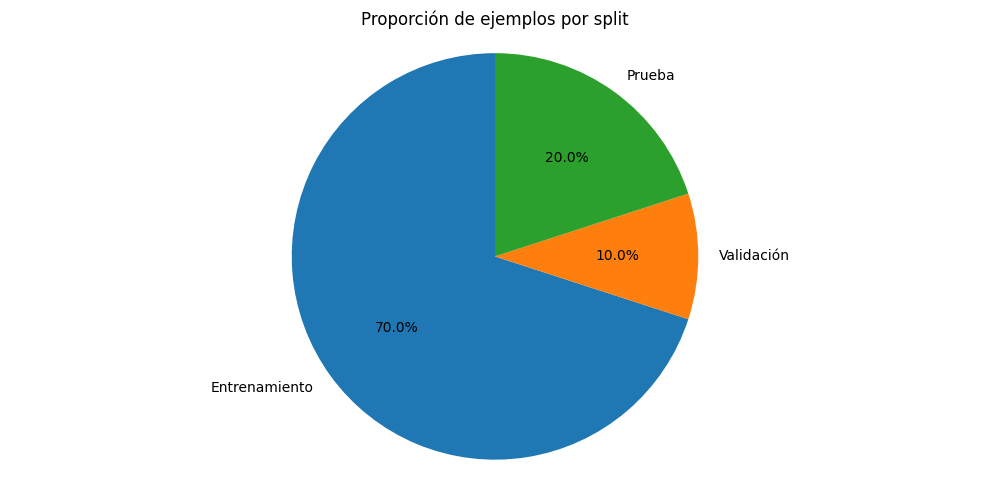

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 📁 Ruta de tus archivos CSV
train_path = "soroban_train.csv"
val_path = "soroban_val.csv"
test_path = "soroban_test.csv"

# 📦 Cargar los splits
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

# 📊 Crear diccionario para recorrer todos
splits = {
    "Entrenamiento": df_train,
    "Validación": df_val,
    "Prueba": df_test
}

# 📈 Función auxiliar para mostrar estadísticas
def mostrar_estadisticas(nombre, df):
    print(f"\n📌 Split: {nombre}")
    print(f"- Cantidad de ejemplos: {len(df)}")
    print("- Distribución por kyu:")
    print(df["kyu"].value_counts().sort_index())
    print("- Distribución por dificultad:")
    print(df["diff"].value_counts().sort_index())
    print("- Distribución por longitud:")
    print(df["len"].value_counts().sort_index())

# 📊 Mostrar estadísticas por split
for nombre, df in splits.items():
    mostrar_estadisticas(nombre, df)

# 📈 Comparativa visual
plt.figure(figsize=(10, 5))
sizes = [len(df_train), len(df_val), len(df_test)]
labels = ["Entrenamiento", "Validación", "Prueba"]
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Proporción de ejemplos por split")
plt.axis("equal")
plt.tight_layout()
plt.show()


# 5 Tokenización
### Convertir texto a una representación numérica entendible por el modelo (como embeddings)

In [18]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict({
    "train": Dataset.from_pandas(pd.read_csv("soroban_train.csv")),
    "validation": Dataset.from_pandas(pd.read_csv("soroban_val.csv")),
    "test": Dataset.from_pandas(pd.read_csv("soroban_test.csv")),
})


## Se usa el modelo t5-small

In [19]:
from transformers import AutoTokenizer

# 1. Elegimos un modelo base compatible
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 2. Función de preprocesamiento
def preprocess_function(examples):
    inputs = examples["X"]
    targets = examples["Y"]

    model_inputs = tokenizer(inputs, max_length=64, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=64, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# 3. Aplicar al dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Map:   0%|          | 0/239926 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/34276 [00:00<?, ? examples/s]

Map:   0%|          | 0/68550 [00:00<?, ? examples/s]

# 6 Entrenamiento

#Misceláneos

El código de abajo es el que genera los ejercicios de forma aleatoria. Perdir poder ajustar la cantidad de terms (ejericcios en una linea)

In [ ]:
import random

KYU_RULES = {
    13: {"add": {"terms": 5, "digits": 1}, "sub": {"terms": 5, "digits": 1}},
    12: {"add": {"terms": 6, "digits": 1}, "sub": {"terms": 6, "digits": 1}},
    11: {"add": {"terms": 7, "digits": 1}, "sub": {"terms": 7, "digits": 1}},
    10: {"add": {"terms": 5, "digits": 2}, "sub": {"terms": 5, "digits": 2}},
    9:  {"add": {"terms": 6, "digits": 2}, "sub": {"terms": 6, "digits": 2},
         "mul": {"left": 2, "right": 1}, "div": {"dividend": 3, "divisor": 1}},
    8:  {"add": {"terms": 7, "digits": 2}, "sub": {"terms": 7, "digits": 2},
         "mul": {"left": 2, "right": 2}, "div": {"dividend": 4, "divisor": 1}},
    7:  {"add": {"terms": 8, "digits": 2}, "sub": {"terms": 8, "digits": 2},
         "mul": {"left": 3, "right": 1}, "div": {"dividend": 4, "divisor": 2}},
    6:  {"add": {"terms": 6, "digits": 3}, "sub": {"terms": 6, "digits": 3},
         "mul": {"left": 3, "right": 2}, "div": {"dividend": 5, "divisor": 2}},
    5:  {"add": {"terms": 7, "digits": 3}, "sub": {"terms": 7, "digits": 3},
         "mul": {"left": 3, "right": 3}, "div": {"dividend": 6, "divisor": 2}},
    4:  {"add": {"terms": 8, "digits": 3}, "sub": {"terms": 8, "digits": 3},
         "mul": {"left": 4, "right": 2}, "div": {"dividend": 6, "divisor": 3}},
    3:  {"add": {"terms": 6, "digits": 4}, "sub": {"terms": 6, "digits": 4},
         "mul": {"left": 4, "right": 3}, "div": {"dividend": 7, "divisor": 3}},
    2:  {"add": {"terms": 7, "digits": 4}, "sub": {"terms": 7, "digits": 4},
         "mul": {"left": 4, "right": 4}, "div": {"dividend": 8, "divisor": 3}},
    1:  {"add": {"terms": 8, "digits": 4}, "sub": {"terms": 8, "digits": 4},
         "mul": {"left": 5, "right": 4}, "div": {"dividend": 9, "divisor": 4}},
}

def rand_ndigits(rng, d):
    if d <= 1:
        return rng.randint(1, 9)
    lo = 10**(d-1)
    hi = 10**d - 1
    return rng.randint(lo, hi)

def gen_add(rng, terms, digits):
    nums = [rand_ndigits(rng, digits) for _ in range(terms)]
    return " + ".join(map(str, nums)), sum(nums)

def gen_sub(rng, terms, digits):
    nums = [rand_ndigits(rng, digits) for _ in range(terms)]
    nums.sort(reverse=True)  # evita negativos
    res = nums[0]
    for x in nums[1:]:
        res -= x
    return " - ".join(map(str, nums)), res

def gen_mul(rng, left_d, right_d):
    a = rand_ndigits(rng, left_d)
    b = rand_ndigits(rng, right_d)
    return f"{a} × {b}", a * b

def gen_div(rng, dividend_d, divisor_d, exact=True, max_tries=200):
    for _ in range(max_tries):
        a = rand_ndigits(rng, dividend_d)
        b = rand_ndigits(rng, divisor_d)
        if b == 0: continue
        if not exact or a % b == 0:
            return f"{a} ÷ {b}", a // b
    b = max(1, rand_ndigits(rng, divisor_d))
    a = b * rand_ndigits(rng, max(1, dividend_d - divisor_d))
    return f"{a} ÷ {b}", a // b

def build_set(kyu, op, n, seed=1234):
    rng = random.Random(seed)
    rules = KYU_RULES[kyu][op]
    out = []
    for _ in range(n):
        if op == "add":
            expr, ans = gen_add(rng, rules["terms"], rules["digits"])
        elif op == "sub":
            expr, ans = gen_sub(rng, rules["terms"], rules["digits"])
        elif op == "mul":
            expr, ans = gen_mul(rng, rules["left"], rules["right"])
        elif op == "div":
            expr, ans = gen_div(rng, rules["dividend"], rules["divisor"])
        out.append((expr, ans))
    return out

# --- interfaz por pantalla ---
try:
    kyu = int(input("Kyu (1-13): "))
    ejercicios = int(input("Cantidad de ejercicios: "))
    tipo = input("Tipo (add/sub/mul/div): ").strip()
except Exception as e:
    print("Error en la entrada:", e)
    exit()

if kyu not in KYU_RULES or tipo not in KYU_RULES[kyu]:
    print(f"El Kyu {kyu} no tiene definida la operación '{tipo}'")
else:
    lista = build_set(kyu, tipo, ejercicios, seed=42)
    for i, (q, a) in enumerate(lista, 1):
        print(f"{i:02d}. {q} = {a}")


## d) Análisis de Solapamientos

In [13]:
import pandas as pd

# 📁 Cargar splits
df_train = pd.read_csv("soroban_train.csv")
df_val = pd.read_csv("soroban_val.csv")
df_test = pd.read_csv("soroban_test.csv")

# 🔍 Armar tuplas únicas de (X, Y)
train_pairs = set(zip(df_train["X"], df_train["Y"]))
val_pairs = set(zip(df_val["X"], df_val["Y"]))
test_pairs = set(zip(df_test["X"], df_test["Y"]))

# 🔁 Comparar intersecciones
val_overlap = train_pairs.intersection(val_pairs)
test_overlap = train_pairs.intersection(test_pairs)
test_val_overlap = val_pairs.intersection(test_pairs)

# 📊 Mostrar resultados
print(f"🔁 Coincidencias train ↔ val: {len(val_overlap)}")
print(f"🔁 Coincidencias train ↔ test: {len(test_overlap)}")
print(f"🔁 Coincidencias val ↔ test: {len(test_val_overlap)}")

# (Opcional) Ver algunos duplicados
if val_overlap:
    print("\n🔎 Ejemplos duplicados entre train y val:")
    print(list(val_overlap)[:3])

if test_overlap:
    print("\n🔎 Ejemplos duplicados entre train y test:")
    print(list(test_overlap)[:3])

if test_val_overlap:
    print("\n🔎 Ejemplos duplicados entre val y test:")
    print(list(test_val_overlap)[:3])


🔁 Coincidencias train ↔ val: 2962
🔁 Coincidencias train ↔ test: 5552
🔁 Coincidencias val ↔ test: 1115

🔎 Ejemplos duplicados entre train y val:
[('<add_sub> <kyu:13> <diff:3> <add_and_sub> <len:4>', '4 + 8 + -6 + 8'), ('<add_sub> <kyu:12> <diff:2> <add_and_sub> <len:5>', '3 + 3 + 9 + 5 + -1'), ('<add_sub> <kyu:13> <diff:2> <add_and_sub> <len:4>', '5 + -2 + 6 + 5')]

🔎 Ejemplos duplicados entre train y test:
[('<add_sub> <kyu:10> <diff:1> <only_add> <len:10>', '6 + 1 + 8 + 1 + 6 + 8 + 5 + 2 + 2 + 8'), ('<add_sub> <kyu:13> <diff:2> <only_add> <len:4>', '7 + 4 + 4 + 2'), ('<add_sub> <kyu:13> <diff:2> <only_add> <len:4>', '1 + 8 + 4 + 2')]

🔎 Ejemplos duplicados entre val y test:
[('<add_sub> <kyu:13> <diff:2> <only_add> <len:4>', '9 + 4 + 7 + 5'), ('<add_sub> <kyu:10> <diff:2> <only_add> <len:10>', '2 + 3 + 4 + 9 + 5 + 6 + 9 + 9 + 7 + 7'), ('<add_sub> <kyu:13> <diff:2> <add_and_sub> <len:4>', '2 + 9 + 4 + -9')]


## e) Limpieza de Duplicados

Busca duplicados en la columna X entre los conjuntos.

Elimina los duplicados de val y test, manteniendo train intacto (esto es intencional porque es el que se usa para el aprendizaje).

Guarda tres nuevos archivos limpios para continuar el entrenamiento.

In [14]:
import pandas as pd

# 📂 Cargar los datasets originales
train = pd.read_csv("soroban_train.csv")
val = pd.read_csv("soroban_val.csv")
test = pd.read_csv("soroban_test.csv")

# 🔑 Elegimos la columna de comparación (la entrada 'X')
col_clave = "X"

# 👣 Paso 1: Detectar duplicados entre splits
val_dup = val[val[col_clave].isin(train[col_clave])]
test_dup = test[test[col_clave].isin(train[col_clave]) | test[col_clave].isin(val[col_clave])]

print("🔁 Ejemplos duplicados eliminados:")
print(f"- val ∩ train: {len(val_dup)}")
print(f"- test ∩ train/val: {len(test_dup)}")

# ✂️ Paso 2: Filtrar duplicados
val_limpio = val[~val[col_clave].isin(train[col_clave])]
test_limpio = test[~test[col_clave].isin(train[col_clave]) & ~test[col_clave].isin(val[col_clave])]

# 🧼 Reconfirmamos tamaños nuevos
print("\n✅ Nuevas cantidades después de limpiar:")
print(f"- Train: {len(train)}")
print(f"- Val:   {len(val_limpio)}")
print(f"- Test:  {len(test_limpio)}")

# 💾 Guardar a CSV
train.to_csv("soroban_train_limpio.csv", index=False)
val_limpio.to_csv("soroban_val_limpio.csv", index=False)
test_limpio.to_csv("soroban_test_limpio.csv", index=False)
print("\n📁 Archivos guardados: 'soroban_train_limpio.csv', 'soroban_val_limpio.csv', 'soroban_test_limpio.csv'")


🔁 Ejemplos duplicados eliminados:
- val ∩ train: 34276
- test ∩ train/val: 68550

✅ Nuevas cantidades después de limpiar:
- Train: 239926
- Val:   0
- Test:  0

📁 Archivos guardados: 'soroban_train_limpio.csv', 'soroban_val_limpio.csv', 'soroban_test_limpio.csv'


Todo val estaba contenido dentro de train (100% solapamiento).

Todo test estaba contenido dentro de train y/o val (100% solapamiento).

🔍 ¿Por qué puede ocurrir esto?

El shuffle y split no fueron estratificados ni aleatorios por semilla fija, por lo que al dividir, podrían haber salido secuencias repetidas sin control.

No se eliminaron duplicados antes de dividir. Si el dataset original ya tenía muchas repeticiones, estas se distribuyeron por igual en los splits.

La columna usada (X) no tiene suficiente variabilidad. Tal vez muchas expresiones coinciden por su estructura.

## d) Re-división

In [15]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

# 📥 Cargar dataset original limpio (sin splits)
df = pd.read_csv("soroban_dataset_xy.csv")

# 🔍 Eliminar duplicados por entrada (X)
df = df.drop_duplicates(subset=["X"])

# ✂️ Dividir en splits: 70% train, 20% test, 10% val
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=2/3, random_state=42)

# 💾 Guardar nuevos datasets
df_train.to_csv("soroban_train_limpio.csv", index=False)
df_val.to_csv("soroban_val_limpio.csv", index=False)
df_test.to_csv("soroban_test_limpio.csv", index=False)

print("✅ Nuevos splits generados sin solapamientos y guardados")


✅ Nuevos splits generados sin solapamientos y guardados


### Se vuelve a verificar duplicados

In [17]:
# 📊 Mostrar estadísticas de la operación
total_original = len(pd.read_csv("soroban_dataset_xy.csv"))  # Longitud original sin limpiar
total_limpio = len(df)  # Ya tiene los duplicados eliminados
duplicados_eliminados = total_original - total_limpio

print("\n📌 Estadísticas del procesamiento:")
print(f"🔢 Total original: {total_original}")
print(f"🧹 Duplicados eliminados: {duplicados_eliminados}")
print(f"📈 Total después de limpiar: {total_limpio}")
print(f"📊 Split final -> Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")



📌 Estadísticas del procesamiento:
🔢 Total original: 342752
🧹 Duplicados eliminados: 342662
📈 Total después de limpiar: 90
📊 Split final -> Train: 63, Val: 9, Test: 18


In [16]:
# 📥 Cargar los splits recién generados
train = pd.read_csv("soroban_train_limpio.csv")
val = pd.read_csv("soroban_val_limpio.csv")
test = pd.read_csv("soroban_test_limpio.csv")

# 🧪 Buscar duplicados entre los splits (usando la columna 'X')
def comparar_duplicados(df1, df2, nombre1, nombre2):
    inter = pd.merge(df1[["X"]], df2[["X"]], on="X")
    print(f"🧾 Coincidencias {nombre1} ↔ {nombre2}: {len(inter)}")
    if not inter.empty:
        print(inter.sample(3))

comparar_duplicados(train, val, "train", "val")
comparar_duplicados(train, test, "train", "test")
comparar_duplicados(val, test, "val", "test")


🧾 Coincidencias train ↔ val: 0
🧾 Coincidencias train ↔ test: 0
🧾 Coincidencias val ↔ test: 0
